In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
TRAIN_PATH = "/kaggle/input/5-flowers-image-classification/train"
TEST_PATH = "/kaggle/input/5-flowers-image-classification/test"

In [ ]:
import torch
import numpy as np
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import os

In [ ]:
from sklearn.model_selection import train_test_split

In [51]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [52]:
train_data = ImageFolder(
    TRAIN_PATH,
    transform = transform
)

In [53]:
# ??transforms.ToTensor

In [54]:
# class TestData(Dataset):
#     def __init__(self, path):
#         self.path = path

In [55]:
import matplotlib.pyplot as plt

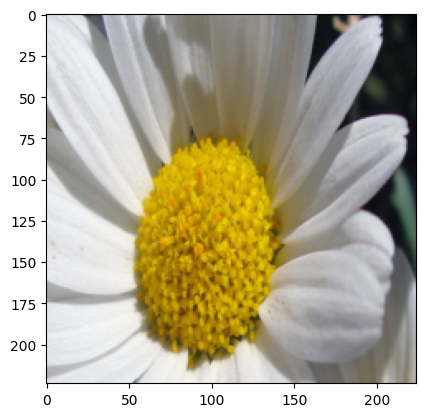

In [56]:
plt.imshow(train_data[1][0].permute(1, 2, 0));

In [57]:
train_data.class_to_idx

{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}

In [58]:
class_map = {v: k for k,v in train_data.class_to_idx.items()}
class_map

{0: 'daisy', 1: 'dandelion', 2: 'rose', 3: 'sunflower', 4: 'tulip'}

In [59]:
len(train_data)

3865

In [60]:
train, val = train_test_split(train_data, test_size = 0.2, random_state = 42)

In [61]:
len(train),len(val)

(3092, 773)

In [62]:
train_loader = DataLoader(train, batch_size = 32, shuffle = True)
val_loader = DataLoader(val, batch_size = 32, shuffle = True)

In [63]:
class FlowerClassifier(nn.Module):
    def __init__(self, n_classes = 5):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32  ,kernel_size = 3, stride= 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),

            nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),


            nn.Flatten()
        )
        self.classifier = nn.Linear(64*56*56, n_classes)

    def forward(self, x):
        x = self.model(x)
        x = self.classifier(x)
        return x

In [64]:
from torch.optim import Adam
model = FlowerClassifier()
optimizer = Adam(model.parameters(), lr = 0.001)
loss_fn = nn.CrossEntropyLoss()

In [65]:
for epoch in range(5):
    total_loss = 0.0
    total_val_loss = 0.0
    for image, label in train_loader:
        optimizer.zero_grad()
        output = model(image)
        loss = loss_fn(output, label)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    model.eval()
    for val_image, val_label in val_loader:
        with torch.no_grad():
            output = model(val_image)
            val_loss = loss_fn(output, val_label)
            total_val_loss += val_loss.item()
    avg_loss = total_loss/len(train_loader)
    avg_val_loss = total_val_loss/len(val_loader)
    print(f"Epoch: {epoch}==========> loss: {avg_loss} ========> val loss: {avg_val_loss}")

Epoch: 0==========> loss: 1.7105289095455838 ========> val loss: 1.4612568950653075
Epoch: 1==========> loss: 1.3015782286211388 ========> val loss: 1.254807848930359
Epoch: 2==========> loss: 1.134106193621134 ========> val loss: 1.19411274433136
Epoch: 3==========> loss: 1.0110807879683898 ========> val loss: 1.1617059564590455
Epoch: 4==========> loss: 0.8844885285367671 ========> val loss: 1.1195655298233032


In [66]:
torch.save(model, '/kaggle/working/flower_clf.pth')
torch.save(model.state_dict(), '/kaggle/working/flower_clf_weights.pth')

In [81]:
model = torch.load('/kaggle/working/flower_clf.pth', weights_only = False)
# model = FlowerClassifier().load_state_dict(model)

In [68]:
# model.train()
from PIL import Image

In [69]:
class TestData(Dataset):
    def __init__(self, path):
        arrays = []
        files = os.listdir(path)
        for file in files:
            image_path = os.path.join(path, file)
            image = Image.open(image_path)
            image = image.resize((224, 224))
            transform = transforms.ToTensor()
            array = transform(image)
            arrays.append(array)

        self.data = torch.stack(arrays)
        
    def __getitem__(self, idx):
        return self.data[idx]

    
    def __len__(self):
        return len(self.data)
        

In [70]:
test_data = TestData(TEST_PATH)
test_data

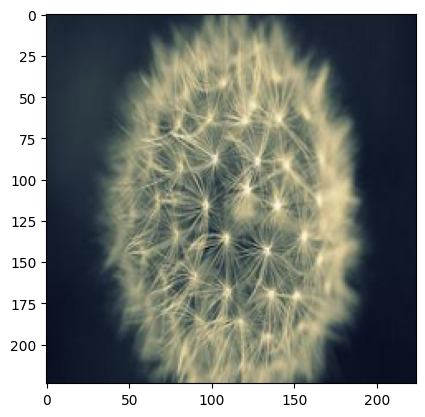

In [71]:
plt.imshow(test_data[0].permute(1,2,0));

In [72]:
len(test_data)

400

In [73]:
test_loader = DataLoader(test_data , batch_size = 32, shuffle = True)

In [84]:
test_data.data.shape

torch.Size([400, 3, 224, 224])

In [85]:
model.eval()
with torch.no_grad():
    y = model(test_data.data)
print(y)

tensor([[  0.5989,   2.1285,  -0.6802,  -1.4939,  -0.7659],
        [  0.5092,   0.7344,  -0.6717,  -1.1349,  -0.8364],
        [  0.3917,   2.2489,  -1.1896,  -2.2050,  -0.5389],
        ...,
        [  0.5209,   1.7534,  -1.3935,  -0.8711,  -0.8858],
        [ -2.5324, -12.3701,   2.2945,  -6.9617,   2.6582],
        [ -0.5297,   1.8868,  -3.1215,   1.4699,  -1.8254]])


In [91]:
predictions = torch.argmax(y, 1)

In [97]:
torch.where(predictions == )

(tensor([], dtype=torch.int64),)

In [101]:
indices = []
for i in range(5):
    index = torch.where(predictions == i)[0][0].item()
    indices.append(index)
indices

[12, 0, 6, 5, 19]

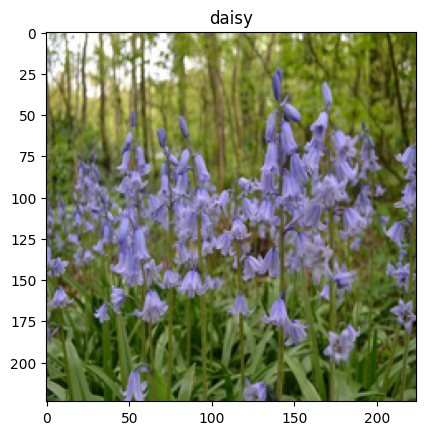

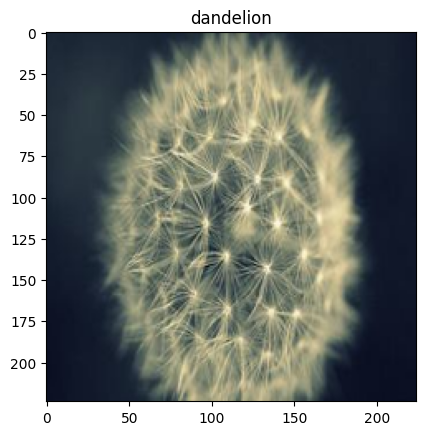

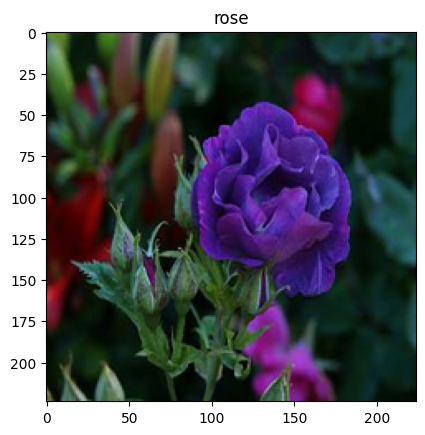

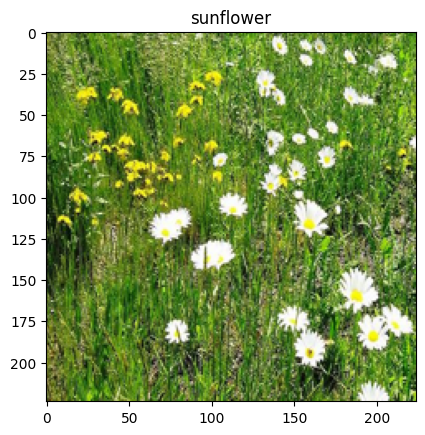

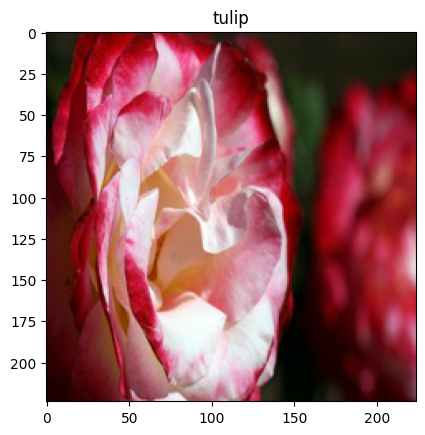

In [104]:
for i in range(5):
    image = test_data[indices[i]]
    plt.imshow(image.permute(1, 2, 0))
    plt.title(f"{class_map.get(i)}")
    plt.show()